<a href="https://colab.research.google.com/github/DanielleRomanoff/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/LS_DS_Unit_4_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [0]:
import pandas as pd
import numpy as np
import requests
from __future__ import print_function

import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image, ImageOps  # https://pillow.readthedocs.io/en/stable/


from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.utils import np_utils
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import hashing_trick
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import preprocess_input, decode_predictions

from tpot import TPOTRegressor

from google_images_download import google_images_download

from twitterscraper import query_tweets

In [2]:
!pip install twitterscraper

In [11]:
austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
INFO

181

In [12]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

In [13]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [14]:
al_tweets[0].text

'Another blast from the past: my heart-to-heart chat with Britney Spears http://bit.ly/bH8o0m'

In [15]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [0]:
# for austen_text in austen_tweets:
#     austen_text = austen_text.text
# #     print(austen_text)
# print(len(austen_text))

In [0]:
# for al_text in al_tweets:
#     al_text = al_text.text
# #     print(al_text)
# print(len(al_text))

In [26]:
# encode characters
tweets_text = ''
for twt in austen_tweets:
    tweets_text += twt.text
for twt in al_tweets:
    tweets_text += twt.text
    
chars = list(set(tweets_text))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

austen_encoded = []
for twt in austen_tweets:
    austen_encoded.append([char_indices[char] for char in twt.text])
al_encoded = []
for twt in al_tweets:
    al_encoded.append([char_indices[char] for char in twt.text])
    
print(austen_encoded)
print("______________________________________________")
print(f"Data Length (Total number of chars): {len(austen_encoded)}")
print()
print(al_encoded)
print("______________________________________________")
print(f"Data Length (Total number of chars): {len(al_encoded)}")



[[10, 92, 68, 34, 51, 88, 92, 68, 34, 51, 88, 92, 68, 34, 51, 88, 92, 3, 34, 76, 41, 28, 1, 80, 92, 3, 28, 7, 56, 92, 80, 76, 88, 83, 7, 92, 33, 88, 34, 33, 68, 88, 75, 33, 28, 97, 75, 7, 3, 28, 7, 7, 88, 76, 75, 97, 34, 39, 26, 104, 42, 84, 72, 39, 0, 63, 68], [69, 88, 78, 70, 92, 7, 56, 88, 92, 28, 39, 33, 83, 97, 7, 92, 3, 83, 78, 92, 39, 88, 1, 7, 28, 34, 1, 88, 94, 92, 28, 1, 92, 7, 56, 88, 92, 59, 101, 40], [99, 28, 78, 41, 78, 92, 28, 1, 92, 38, 54, 88, 76, 21, 78, 92, 59, 40, 58, 90, 90, 42, 34, 39, 33, 88, 7, 28, 7, 34, 76, 78, 90, 18, 88, 68, 88, 7, 88, 38, 54, 88, 76, 90, 99, 88, 33, 100, 7, 83, 7, 28, 34, 1, 90, 90, 67, 26, 24, 92, 83, 76, 88, 92, 78, 88, 68, 104, 101, 28, 1, 104, 68, 28, 97, 7, 88, 94, 92, 48, 83, 1, 94, 92, 28, 104, 92, 28, 7, 92, 3, 88, 76, 88, 1, 21, 7, 92, 104, 34, 76, 92, 18, 88, 68, 88, 7, 88, 38, 54, 88, 76, 92, 43, 5, 104, 7, 92, 39, 28, 80, 56, 7, 92, 54, 88, 92, 97, 68, 34, 78, 88, 92, 7, 34, 92, 94, 88, 83, 94, 70, 92, 78, 34, 92, 83, 68, 39, 34

In [0]:
# proper format for austen's tweets  (positive class = austen's tweets)
# Use Keras to fit a predictive model, classifying tweets as being  from Austen versus Weird Al
austen = pd.DataFrame({'enc' : [e for e in austen_encoded], 'target' : [1] * len(austen_tweets)})
al = pd.DataFrame({'enc' : [e for e in al_encoded], 'target' : [0] * len(al_tweets)})
both = pd.concat([austen, al], ignore_index=True)

# train test split
max_tweet_length = 280
X = sequence.pad_sequences(both.enc, maxlen=max_tweet_length)
y = both.target

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, stratify=y)

In [34]:
batch_size = 32

# Predictive Model using Keras
model = Sequential()
model.add(Embedding(max_tweet_length, 128))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         35840     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 127,541
Trainable params: 127,541
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Instructions for updating:
Use tf.cast instead.
Train on 912 samples, validate on 229 samples
Epoch 1/15
912/912 [==============================] - 11s 12ms/step - loss: 0.4929 - acc: 0.8289 - val_loss: 0.3427 - val_acc: 0.8821
Epoch 2/15
912/912 [==============================] - 10s 11ms/step - loss: 0.3268 - acc: 0.8816 - val_loss: 0.3046 - val_acc: 0.8952
Epoch 3/15
912/912 [==============================] - 10s 11ms/step - loss: 0.2665 - acc: 0.8936 - val_loss: 0.3033 - val_acc: 0.8996
Epoch 4/15
912/912 [==============================] - 10s 11ms/step - loss: 0.2584 - acc: 0.9002 - val_loss: 0.2674 - val_acc: 0.8996
Epoch 5/15
912/912 [==============================] - 10s 11ms/step - loss: 0.2338 - acc: 0.9101 - val_loss: 0.2661 - val_acc: 0.9214
Epoch 6/15
912/912 [==============================] - 10s 11ms/step - loss: 0.2092 - acc: 0.9254 - val_loss: 0.2622 - val_acc: 0.9214
Epoch 7/15
912/912 [==============================] - 10s 11ms/step - loss: 0.2030 - acc: 0.9

Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [8]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 7.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [9]:
response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 4. alligator-animal-on-pond.jpg
Image URL: https://www.nwf.org/-/media/NEW-WEBSITE/Programs/Garden-for-Wildlife/amphibian_bronze-frog_Julia-Bartosh_400x267.ashx
Completed Image ====> 5. amphibian_bronze-frog_julia-bartosh_400x267.ash

Errors: 0



At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [80]:
absolute_image_paths

{'animal pond': ['/content/downloads/animal pond/1. pondanimals.gif',
  '/content/downloads/animal pond/2. hqdefault.jpg',
  '/content/downloads/animal pond/3. pkls4116_inline.png',
  '/content/downloads/animal pond/4. alligator-animal-on-pond.jpg',
  '/content/downloads/animal pond/5. amphibian_bronze-frog_julia-bartosh_400x267.ash']}

In [0]:
# Resize all images to 224x224 pixels
image_path_list = absolute_image_paths['animal pond']

def resize_image(filename, new_width=256, new_height=256):
  pil_image = Image.open(filename)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

for path in image_path_list:
  resize_image(path, 224, 224)

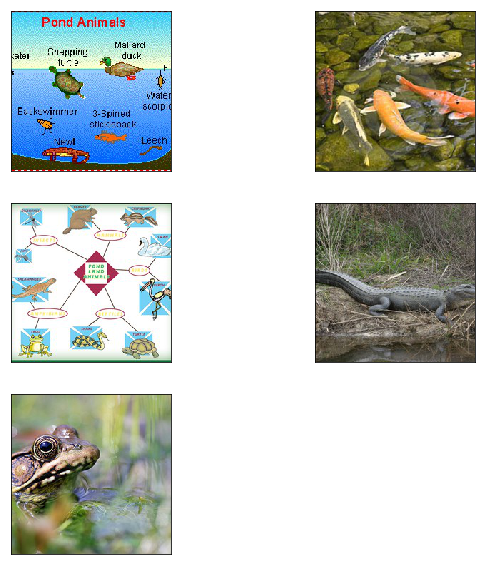

In [84]:
# Show images
def show_images(image_path_list):
  plt.figure(figsize=(10,10));
  for i, image_path in enumerate(image_path_list):
    plt.subplot(3,2, i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
#     plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images(image_path_list)

In [0]:
def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def interpret(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  return results

In [86]:
all_predictions = []
for i, image_path in enumerate(image_path_list):
  results = interpret(process_img_path(image_path))
  all_predictions.append(results)
  print(results)

Instructions for updating:
Colocations handled automatically by placer.
40960/35363 [==================================] - 0s 0us/step
[('n06359193', 'web_site', 0.89183867), ('n04404412', 'television', 0.0854772), ('n04152593', 'screen', 0.006043818)]
[('n01443537', 'goldfish', 0.57714283), ('n02536864', 'coho', 0.3193864), ('n01630670', 'common_newt', 0.020655056)]
[('n04243546', 'slot', 0.9574488), ('n04476259', 'tray', 0.014238203), ('n03908618', 'pencil_box', 0.0073840627)]
[('n01698640', 'American_alligator', 0.5908741), ('n01737021', 'water_snake', 0.13598232), ('n01697457', 'African_crocodile', 0.074790955)]
[('n01641577', 'bullfrog', 0.6603653), ('n01644900', 'tailed_frog', 0.3108621), ('n01630670', 'common_newt', 0.012726531)]


 66.04% chance of bullfrog 
 31.09% chance of tailed_frog 
  1.27% chance of common_newt 


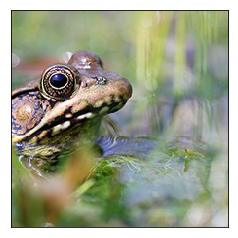

In [89]:
for path, prediction in zip(image_path_list, all_predictions):
  
  # If any of the predictions for an image include the word 'frog', 
  # print out all the predictions as well as the image.
  if any(['frog' in x[1] for x in prediction]):

    for _, animal, prob in prediction:
      print(f'{prob*100:6.2f}% chance of {animal} ')

    plt.subplot()
    plt.imshow(np.asarray(Image.open(path)))
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    print()

 57.71% chance of goldfish 
 31.94% chance of coho 
  2.07% chance of common_newt 


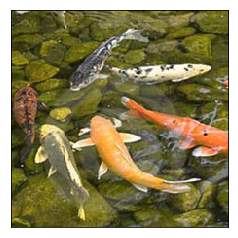

In [90]:
for path, prediction in zip(image_path_list, all_predictions):
  
  # If any of the predictions for an image include the word 'frog', 
  # print out all the predictions as well as the image.
  if any(['fish' in x[1] for x in prediction]):
    
    for _, animal, prob in prediction:
      print(f'{prob*100:6.2f}% chance of {animal} ')

    plt.subplot()
    plt.imshow(np.asarray(Image.open(path)))
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    print()

 59.09% chance of American_alligator 
 13.60% chance of water_snake 
  7.48% chance of African_crocodile 


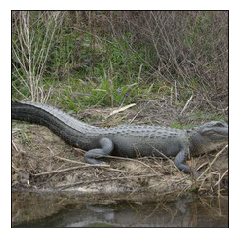

In [91]:
for path, prediction in zip(image_path_list, all_predictions):
  
  # If any of the predictions for an image include the word 'frog', 
  # print out all the predictions as well as the image.
  if any(['alligator' in x[1] for x in prediction]):
    
    for _, animal, prob in prediction:
      print(f'{prob*100:6.2f}% chance of {animal} ')

    plt.subplot()
    plt.imshow(np.asarray(Image.open(path)))
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    print()

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [10]:
!pip install tpot

    100% |████████████████████████████████| 81kB 3.1MB/s 
    100% |████████████████████████████████| 942kB 12.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built stopit deap


In [11]:
!wget https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv

--2019-04-12 15:31:07--  https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  --.-KB/s    in 0.09s   

2019-04-12 15:31:07 (26.3 MB/s) - ‘kc_house_data.csv’ saved [2515206/2515206]



In [12]:
!head kc_house_data.csv

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000
"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503
"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930
"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003",47.3097,-122.327,2238,6819
"2

In [0]:
kc_house_data = pd.read_csv('kc_house_data.csv')

In [110]:
kc_house_data  = kc_house_data [kc_house_data .columns.drop('id')]
kc_house_data  = kc_house_data [kc_house_data .columns.drop('date')]
kc_house_data .head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [111]:
X = kc_house_data.drop(columns='price').values
y = kc_house_data['price'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

print(X_train.shape)
print(y_train.shape)

(16209, 18)
(16209,)


In [0]:
y_train=y_train.reshape(-1,1)

In [114]:
%%time

tpot = TPOTRegressor(generations=3, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: -21180355886.8545


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.1, loss=linear, n_estimators=100), bootstrap=True, max_features=0.3, min_samples_leaf=5, min_samples_split=17, n_estimators=100)
CPU times: user 6min 55s, sys: 11.4 s, total: 7min 7s
Wall time: 6min 54s


## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?
- What area of Data Science would you most like to learn more about, and why?
- Where do you think Data Science will be in 5 years?

A few sentences per answer is fine - only elaborate if time allows.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.

**1)  What do you consider your strongest area, as a Data Scientist?**
My strongest area as of last week was neural networks. They make so much sense to me.

**2) What area of Data Science would you most like to learn more about, and why?**
I would like to go more in depth with Scala and using Spark and AWS. I feel like I'm lacking sufficient knowledge in that area. I also want to learn more about neural networks and combining them to produced desired results. Like a robot recognizing a floor vs. a couch vs. a counter, etc.

**3) Where do you think Data Science will be in 5 years?**
This is a loaded question. In five years, we will have accumulated copius amounts of data. I think we will have a rough 'Rosie' from the Jetsons. I also believe Data Science will continue to expand and raise an enormous amount of ethical issues that will need to be addressed formally.